In [1]:
import cv2
import numpy as np # this module is useful to work with numerical arrays
import torch
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import time
from skimage.util import img_as_ubyte
from ignite.metrics import SSIM

VIDEOS_LOCATION = "C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\\videos\\"

transform = transforms.ToTensor()

width = 640
height = 360


In [2]:
VIDEOS_LOCATION = "C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\\videos\\"
VIDEOS_TRAIN = [
    {
        "file": "soldiers.mp4",
        "fps": None
    },
    {
        "file": 'running.mp4',
        "fps": None
    }
]

VIDEOS_TEST = [
    {
        "file": 'nato.mp4',
        "fps": None
    }
]

VIDEOS_SKI_TRAIN = [
    {
        "file": 'drone_shot.mp4',
        "fps": None
    },
    {
        "file": "crevace2.mp4",
        "fps": None
    }
]

VIDEOS_SKI_TEST = [
    {
        "file": "powder_maybe2.mp4",
        "fps": None
    }
]

class VideoDataLoader:
    video_index = 0
    videos = None
    cap = None
    frame_batch_buffer = []
    first_frame = None
    def __init__(self, videos):
        self.videos = videos
        self.cap = cv2.VideoCapture(VIDEOS_LOCATION + self.videos[self.video_index]["file"])
        self.videos[self.video_index]["fps"] = self.cap.get(cv2.CAP_PROP_FPS)
        if not self.cap.isOpened():
            print("Error: could not open video file")
        ret, first_frame = self.cap.read()
        for i in range(10):
            ret, middle_frame = self.cap.read()
            if not ret:
                break
            ret, last_frame = self.cap.read()
            if not ret:
                break
            batch_of_frames = [transform(first_frame), transform(middle_frame), transform(last_frame)]
            self.frame_batch_buffer.append(batch_of_frames)
            first_frame = last_frame
        self.first_frame = first_frame

    def hasNext(self):
        return len(self.frame_batch_buffer) != 0

    def reload_buffer(self, videos):
        self.frame_batch_buffer = []
        self.video_index = 0
        self.__init__(videos)

    def nextFile(self):
        self.video_index += 1
        self.cap.release()
        try:
            self.cap = cv2.VideoCapture(VIDEOS_LOCATION + self.videos[self.video_index]["file"])
        except:
            batch = self.frame_batch_buffer.pop(0)
            self.frame_batch_buffer = []
            return batch

        self.videos[self.video_index]["fps"] = self.cap.get(cv2.CAP_PROP_FPS)
        if not self.cap.isOpened():
            print("Error: could not open video file")
        ret, first_frame = self.cap.read()
        for i in range(10):
            ret, middle_frame = self.cap.read()
            if not ret:
                break
            ret, last_frame = self.cap.read()
            if not ret:
                break
            batch_of_frames = [transform(first_frame), transform(middle_frame), transform(last_frame)]
            self.frame_batch_buffer.append(batch_of_frames)
            first_frame = last_frame
        self.first_frame = first_frame
        return self.frame_batch_buffer.pop(0)

    def getNext(self):
        if len(self.frame_batch_buffer) < 5:
            return self.nextFile()
        ret, middle_frame = self.cap.read()
        if not ret:
            return self.nextFile()
        ret, last_frame = self.cap.read()
        if not ret:
            return self.nextFile()

        batch_of_frames = [transform(self.first_frame), transform(middle_frame), transform(last_frame)]
        # batch_of_frames = [self.first_frame, middle_frame, last_frame]
        self.frame_batch_buffer.append(batch_of_frames)
        self.first_frame = last_frame
        # cv2.imshow('batch_of_frames', middle_frame)
        # cv2.imshow('batch_of_frames', last_frame)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     cv2.destroyAllWindows()
        #     self.frame_batch_buffer = []
        return self.frame_batch_buffer.pop(0)


In [3]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.lefthand_first = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.righthand_first = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.lefthand_second = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.righthand_second = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.lefthand_third = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.righthand_third = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.decoder_third = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )

        self.decoder_second = nn.Sequential(
            nn.ConvTranspose2d(in_channels=144, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )

        self.decoder_first = nn.Sequential(
            nn.ConvTranspose2d(in_channels=320, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
        )


    def forward(self, left, right):
        left_first = self.lefthand_first(left)
        right_first = self.righthand_first(right)

        first_concat_256c = torch.cat((left_first, right_first), 0)

        left_second = self.lefthand_second(left_first)
        right_second = self.righthand_second(right_first)

        second_concat_128c = torch.cat((left_second, right_second), 0)

        left_third = self.lefthand_third(left_second)
        right_third = self.righthand_third(right_second)

        encoded = torch.cat((left_third, right_third), 0)

        third = self.decoder_third(encoded)

        second_skip = torch.cat((third, second_concat_128c), 0)

        second_no_skip = self.decoder_second(second_skip)

        first_skip = torch.cat((second_no_skip, first_concat_256c), 0)

        x = self.decoder_first(first_skip)
        return x


In [4]:
loss_fn = torch.nn.MSELoss()
# torch.manual_seed(0)

autoencoder = Autoencoder()
params_to_optimize = [
    {'params': autoencoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=0.0001, weight_decay=1e-08)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

autoencoder = autoencoder.to(device)


Selected device: cuda


In [5]:
def testepoch(epoch):
    ssim_metric = SSIM(data_range=1.0)
    videoDataLoader = VideoDataLoader(VIDEOS_TEST)
    videoDataLoader.reload_buffer(VIDEOS_TEST)
    fps = videoDataLoader.videos[0]["fps"]
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    fourcc2 = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter('mark2_video_outs/epoch'+ str(epoch) +'_nato_25vs50fps.avi', fourcc, fps * 2, (width * 2, height), isColor=True)
    out2 = cv2.VideoWriter('mark2_video_outs/epoch'+ str(epoch) +'_nato_12vs25fps.avi', fourcc2, fps, (width * 2, height), isColor=True)
    autoencoder.eval()
    i = 0
    with torch.no_grad():
        test_loss = []
        ssim = []
        while videoDataLoader.hasNext():
            batch = videoDataLoader.getNext()
            first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
            original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

            first_frame = batch[0].to(device)
            middle_frame = batch[1].to(device)
            last_frame = batch[2].to(device)

            res_frame = autoencoder(first_frame, last_frame)
            res_frame1 = autoencoder(first_frame, middle_frame)
            res_frame2 = autoencoder(middle_frame, last_frame)

            middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
            middle_f1 = np.transpose(res_frame1.cpu().data.numpy(), (1, 2, 0))
            middle_f2 = np.transpose(res_frame2.cpu().data.numpy(), (1, 2, 0))
            # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
            # cv2.imshow('generated frame', cv2.hconcat([first_f, middle_f]))
            # if cv2.waitKey(25) & 0xFF == ord('q'):
            #     break

            first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
            middle1_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f1]), 0.0, 1.0))
            middle2_file = img_as_ubyte(np.clip(cv2.hconcat([original_f, original_f]), 0.0, 1.0))
            last_file = img_as_ubyte(np.clip(cv2.hconcat([original_f, middle_f2]), 0.0, 1.0))

            out.write(first_file)
            out.write(middle1_file)
            out.write(middle2_file)
            out.write(last_file)

            middle_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))
            out2.write(first_file)
            out2.write(middle_file)

            # Evaluate loss
            loss = loss_fn(res_frame, middle_frame)
            ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
            ssim_value = ssim_metric.compute()
            ssim.append(ssim_value)

            print('\t %d partial test loss (single batch): %f' % (i, loss.data))
            print('\t %d partial ssim (single batch): %f' % (i, ssim_value))
            i = i + 1
            test_loss.append(loss.detach().cpu().numpy())
        # cv2.destroyAllWindows()
    out.release()
    out2.release()
    return test_loss, ssim

In [5]:
# from torchmetrics import StructuralSimilarityIndexMeasure

# autoencoder.train()

epochs = 5
train_loss_epochs = []
test_loss_epochs = []
ssim_epochs = []
test_ssim_epochs = []
ssim_metric = SSIM(data_range=1.0)
# ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)
for i in range(epochs):
    autoencoder.train()
    train_loss = []
    ssim = []
    # ssim2 = []
    videoDataLoader = VideoDataLoader(VIDEOS_TRAIN)
    videoDataLoader.reload_buffer(VIDEOS_TRAIN)
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)


        # Encode data
        res_frame = autoencoder(first_frame, last_frame)

        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()


        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()


        # ssim.append(ssim_metric(res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        ssim_value = ssim_metric.compute()
        ssim.append(ssim_value)

        # res_frame = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        # first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, res_frame]))
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        # Print batch loss
        print('\t %d partial train loss (single batch): %f' % (i, loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    ssim_epochs.append(ssim)
    # ssim_epochs2.append(ssim2)
    # train_loss_epochs.append(train_loss)
    # test_loss, test_ssim = testepoch(i)
    # test_ssim_epochs.append(test_ssim)
    # test_loss_epochs.append(test_loss)
    # cv2.destroyAllWindows()

	 0 partial train loss (single batch): 0.282024
	 0 partial train loss (single batch): 0.275294
	 0 partial train loss (single batch): 0.269160
	 0 partial train loss (single batch): 0.263172
	 0 partial train loss (single batch): 0.257394
	 0 partial train loss (single batch): 0.251571
	 0 partial train loss (single batch): 0.245543
	 0 partial train loss (single batch): 0.238566
	 0 partial train loss (single batch): 0.229714
	 0 partial train loss (single batch): 0.218644
	 0 partial train loss (single batch): 0.206432
	 0 partial train loss (single batch): 0.192956
	 0 partial train loss (single batch): 0.179141
	 0 partial train loss (single batch): 0.164324
	 0 partial train loss (single batch): 0.149014
	 0 partial train loss (single batch): 0.133489
	 0 partial train loss (single batch): 0.118610
	 0 partial train loss (single batch): 0.104183
	 0 partial train loss (single batch): 0.090492
	 0 partial train loss (single batch): 0.077880
	 0 partial train loss (single batch): 0

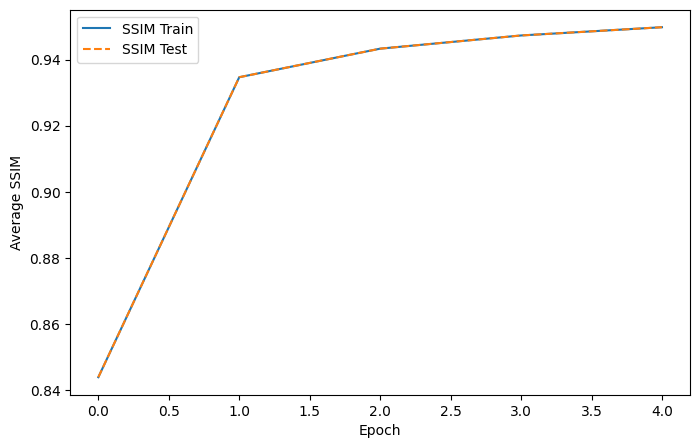

In [6]:
ssim_epochs2 = []
ssim_epochs2_test = []
for ssimepoch in ssim_epochs:
    ssim_epochs2.append(sum(ssimepoch)/len(ssimepoch))
for testssim in test_ssim_epochs:
    ssim_epochs2_test.append(sum(testssim)/len(testssim))
plt.figure(figsize=(8,5))
plt.plot(ssim_epochs2, label='SSIM Train')
plt.plot(ssim_epochs2, label='SSIM Test', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Average SSIM')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [8]:
ssim_epochs2 = []
ssim_epochs2_test = []
for ssimepoch in ssim_epochs:
    ssim_epochs2.append(sum(ssimepoch)/len(ssimepoch))
for testssim in test_ssim_epochs:
    ssim_epochs2_test.append(sum(testssim)/len(testssim))
for i in range(len(ssim_epochs2)):
    ssim_epochs2[i] = abs(ssim_epochs2[i]-ssim_epochs2_test[i])
plt.figure(figsize=(8,5))
plt.plot(ssim_epochs2, label='SSIM Test', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Average SSIM')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

IndexError: list index out of range

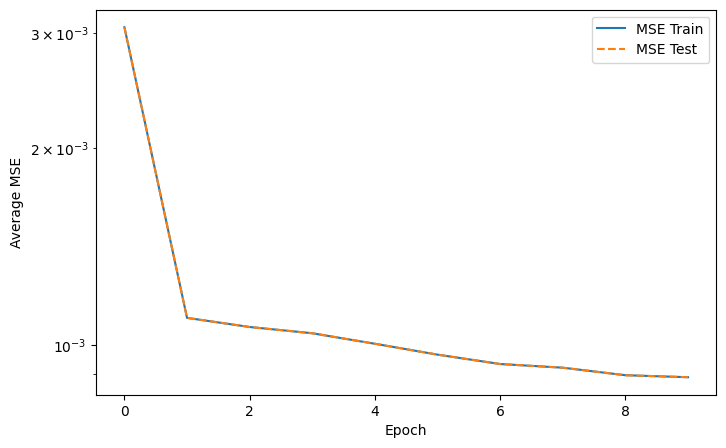

In [12]:
ssim_epochs2 = []
ssim_epochs2_test = []
for ssimepoch in train_loss_epochs:
    ssim_epochs2.append(sum(ssimepoch) / len(ssimepoch))
for testssim in test_loss_epochs:
    ssim_epochs2_test.append(sum(testssim) / len(testssim))
plt.figure(figsize=(8, 5))
plt.semilogy(ssim_epochs2, label='MSE Train')
plt.semilogy(ssim_epochs2, label='MSE Test', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Average MSE')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [13]:
videoDataLoader = VideoDataLoader(VIDEOS_SKI_TEST)
videoDataLoader.reload_buffer(VIDEOS_SKI_TEST)
fps = videoDataLoader.videos[0]["fps"]
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fourcc2 = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('mark2_video_outs/10epochs_ski_30source_60generated_normalised.avi', fourcc, fps, (width * 2, height), isColor=True)
out2 = cv2.VideoWriter('mark2_video_outs/10epochs_ski_120fps_normalised.avi', fourcc, fps * 2, (width * 2, height), isColor=True)
autoencoder.eval()
i = 0
with torch.no_grad():
    test_loss = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)
        res_frame1 = autoencoder(first_frame, middle_frame)
        res_frame2 = autoencoder(middle_frame, last_frame)
        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        middle_f1 = np.transpose(res_frame1.cpu().data.numpy(), (1, 2, 0))
        middle_f2 = np.transpose(res_frame2.cpu().data.numpy(), (1, 2, 0))

        mini = np.min(middle_f)
        maxi = np.max(middle_f)
        middle_f = (middle_f-mini)/(maxi-mini)

        first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
        middle_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))

        out.write(first_file)
        out.write(middle_file)

        middle_file1 = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f1]), 0.0, 1.0))
        middle_org = img_as_ubyte(np.clip(cv2.hconcat([original_f, original_f]), 0.0, 1.0))
        middle_file2 = img_as_ubyte(np.clip(cv2.hconcat([original_f, middle_f2]), 0.0, 1.0))
        out2.write(first_file)
        out2.write(middle_file1)
        out2.write(middle_org)
        out2.write(middle_file2)


        # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, middle_f]))
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)

        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1
        test_loss.append(loss.detach().cpu().numpy())
out.release()
out2.release()


	 0 partial test loss (single batch): 0.000034
	 1 partial test loss (single batch): 0.000034
	 2 partial test loss (single batch): 0.000035
	 3 partial test loss (single batch): 0.000034
	 4 partial test loss (single batch): 0.000034
	 5 partial test loss (single batch): 0.000035
	 6 partial test loss (single batch): 0.000036
	 7 partial test loss (single batch): 0.000034
	 8 partial test loss (single batch): 0.000037
	 9 partial test loss (single batch): 0.000036
	 10 partial test loss (single batch): 0.000036
	 11 partial test loss (single batch): 0.000035
	 12 partial test loss (single batch): 0.000038
	 13 partial test loss (single batch): 0.000037
	 14 partial test loss (single batch): 0.000038
	 15 partial test loss (single batch): 0.000038
	 16 partial test loss (single batch): 0.000044
	 17 partial test loss (single batch): 0.000038
	 18 partial test loss (single batch): 0.000045
	 19 partial test loss (single batch): 0.000047
	 20 partial test loss (single batch): 0.000036
	 

In [9]:
videoDataLoader = VideoDataLoader(VIDEOS_SKI_TEST)
videoDataLoader.reload_buffer(VIDEOS_SKI_TEST)
autoencoder.eval()
i = 0

fps = videoDataLoader.videos[0]["fps"]
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
# out = cv2.VideoWriter('mark2_video_outs/5epochs_nn_norm.avi', fourcc, fps/2, (width, height), isColor=True)

with torch.no_grad():
    test_loss = []
    ssim = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(nn.functional.normalize(batch[1]).numpy(), (1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)

        loss = loss_fn(res_frame, middle_frame)
        test_loss.append(loss.detach().cpu().numpy())
        ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        ssim_value = ssim_metric.compute()
        ssim.append(ssim_value)

        # res_frame = nn.functional.normalize(res_frame)
        #
        # # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        # middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        #
        #
        # middle_file = img_as_ubyte(np.abs(original_f - middle_f))
        # mini = np.min(middle_file)
        # maxi = np.max(middle_file)
        # middle_file = (middle_file-mini)/(maxi-mini)
        # out.write(middle_file)


        # cv2.imshow('generated frame', middle_file)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1

# cv2.destroyAllWindows()
# out.release()

	 0 partial test loss (single batch): 0.000045
	 1 partial test loss (single batch): 0.000045
	 2 partial test loss (single batch): 0.000045
	 3 partial test loss (single batch): 0.000045
	 4 partial test loss (single batch): 0.000044
	 5 partial test loss (single batch): 0.000044
	 6 partial test loss (single batch): 0.000045
	 7 partial test loss (single batch): 0.000043
	 8 partial test loss (single batch): 0.000046
	 9 partial test loss (single batch): 0.000045
	 10 partial test loss (single batch): 0.000044
	 11 partial test loss (single batch): 0.000044
	 12 partial test loss (single batch): 0.000047
	 13 partial test loss (single batch): 0.000046
	 14 partial test loss (single batch): 0.000046
	 15 partial test loss (single batch): 0.000046
	 16 partial test loss (single batch): 0.000051
	 17 partial test loss (single batch): 0.000045
	 18 partial test loss (single batch): 0.000051
	 19 partial test loss (single batch): 0.000054
	 20 partial test loss (single batch): 0.000045
	 

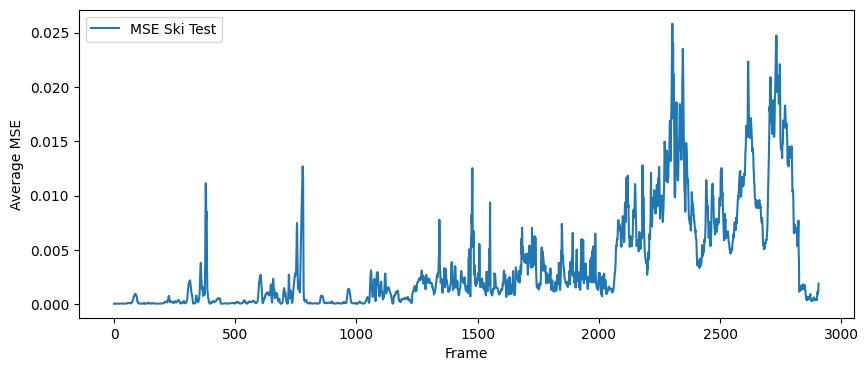

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(test_loss, label='MSE Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average MSE')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

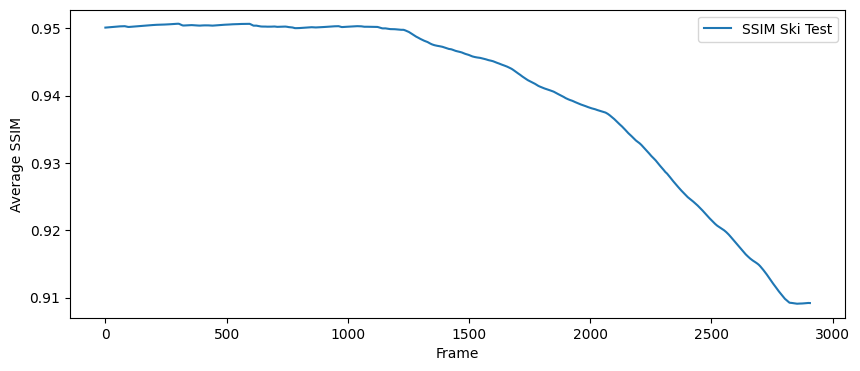

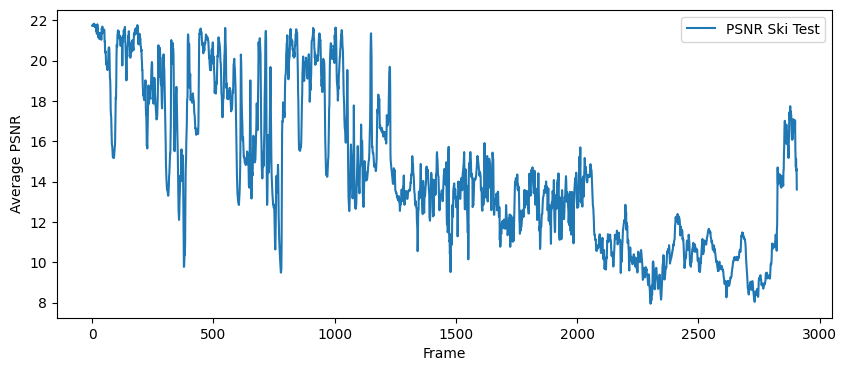

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(ssim, label='SSIM Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average SSIM')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

import math
psnr = []
for err in test_loss:
    psnr.append(10 * math.log10(1.0 / math.sqrt(err)))
plt.figure(figsize=(10, 4))
plt.plot(psnr, label='PSNR Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average PSNR')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [5]:
from ignite.metrics import SSIM
autoencoder.train()

epochs = 5
train_loss_epochs = []
ssim_epochs = []
ssim_metric = SSIM(data_range=1.0)
for i in range(epochs):
    train_loss = []
    ssim = []
    start = time.time()
    videoDataLoader = VideoDataLoader(VIDEOS_TRAIN)
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        # Encode data
        res_frame = autoencoder(first_frame, last_frame)
        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()

        # Display the image using matplotlib

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        ssim_value = ssim_metric.compute()
        ssim.append(ssim_value)
        # Print batch loss
        print('\t %d partial train loss (single batch): %f' % (i, loss.data))
        print('\t %d partial ssim (single batch): %f' % (i, ssim_value))
        train_loss.append(loss.detach().cpu().numpy())
    train_loss_epochs.append(train_loss)
    ssim_epochs.append(ssim)

	 0 partial train loss (single batch): 0.267979
	 0 partial train loss (single batch): 0.255330
	 0 partial train loss (single batch): 0.243333
	 0 partial train loss (single batch): 0.231408
	 0 partial train loss (single batch): 0.219701
	 0 partial train loss (single batch): 0.207800
	 0 partial train loss (single batch): 0.195563
	 0 partial train loss (single batch): 0.182454
	 0 partial train loss (single batch): 0.169193
	 0 partial train loss (single batch): 0.155824
	 0 partial train loss (single batch): 0.142602
	 0 partial train loss (single batch): 0.129167
	 0 partial train loss (single batch): 0.116093
	 0 partial train loss (single batch): 0.102948
	 0 partial train loss (single batch): 0.090114
	 0 partial train loss (single batch): 0.077399
	 0 partial train loss (single batch): 0.065562
	 0 partial train loss (single batch): 0.054548
	 0 partial train loss (single batch): 0.044648
	 0 partial train loss (single batch): 0.036178
	 0 partial train loss (single batch): 0

In [89]:


videoDataLoader = VideoDataLoader(VIDEOS_TEST)
fps = videoDataLoader.videos[0]["fps"]
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('25fpsFromModel_12fpsVS50fps_75fps_generated.avi', fourcc, fps * 2, (width * 2, height), isColor=True)
autoencoder.eval()
i = 0
with torch.no_grad():
    test_loss = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(batch[1].numpy(), (1, 2, 0))
        # first_f = np.array(batch[0].permute(1, 2, 0))
        # original_f = np.array(batch[1].permute(1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)
        # extra1_res_frame = autoencoder(first_frame, middle_frame)
        # extra2_res_frame = autoencoder(middle_frame, last_frame)

        extra1_res_frame = autoencoder(first_frame, res_frame)
        extra2_res_frame = autoencoder(res_frame, last_frame)

        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        # middle_f = np.array(res_frame.cpu().data.permute(1, 2, 0))
        middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        extra1_f = np.transpose(extra1_res_frame.cpu().data.numpy(), (1, 2, 0))
        extra2_f = np.transpose(extra2_res_frame.cpu().data.numpy(), (1, 2, 0))


        # first_frame_file = cv2.cvtColor(first_f, cv2.COLOR_RGB2BGR)
        # middle_frame_file = cv2.cvtColor(middle_f, cv2.COLOR_RGB2BGR)

        # first_frame_file = cv2.cvtColor(first_frame_file, cv2.COLOR_BGR2RGB)
        # middle_frame_file = cv2.cvtColor(middle_frame_file, cv2.COLOR_BGR2RGB)
        # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, middle_f]))
        # cv2.imwrite("output_frames/test_nato_"+str(i)+".jpg", first_f * 255)
        # cv2.imwrite("output_frames/test_nato_"+str(i)+".jpg", middle_f * 255)
        # out.write(cv2.hconcat([first_frame_file, first_frame_file]))
        # out.write(cv2.hconcat([first_frame_file, middle_frame_file]))
        # test = (first_f * 255).astype(np.uint8)
        # first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f, first_f, first_f]), 0.0, 1.0))
        # middle1_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f, first_f, extra1_f]), 0.0, 1.0))
        # middle2_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f, original_f, original_f]), 0.0, 1.0))
        # last_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f, original_f, extra2_f]), 0.0, 1.0))


        first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
        middle1_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, extra1_f]), 0.0, 1.0))
        # middle2_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, original_f]), 0.0, 1.0))
        middle2_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))
        last_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, extra2_f]), 0.0, 1.0))

        out.write(first_file)
        out.write(middle1_file)
        out.write(middle2_file)
        out.write(last_file)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)
        # # Backward pass
        # optim.zero_grad()
        # loss.backward()
        # optim.step()
        # Print batch loss
        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1
        test_loss.append(loss.detach().cpu().numpy())
    # cv2.destroyAllWindows()
out.release()

	 0 partial test loss (single batch): 0.000319
	 1 partial test loss (single batch): 0.001005
	 2 partial test loss (single batch): 0.001766
	 3 partial test loss (single batch): 0.003357
	 4 partial test loss (single batch): 0.004424
	 5 partial test loss (single batch): 0.003877
	 6 partial test loss (single batch): 0.001876
	 7 partial test loss (single batch): 0.001908
	 8 partial test loss (single batch): 0.002505
	 9 partial test loss (single batch): 0.002265
	 10 partial test loss (single batch): 0.002784
	 11 partial test loss (single batch): 0.002014
	 12 partial test loss (single batch): 0.001563
	 13 partial test loss (single batch): 0.001626
	 14 partial test loss (single batch): 0.000781
	 15 partial test loss (single batch): 0.000245
	 16 partial test loss (single batch): 0.000431
	 17 partial test loss (single batch): 0.000340
	 18 partial test loss (single batch): 0.000390
	 19 partial test loss (single batch): 0.000263
	 20 partial test loss (single batch): 0.000343
	 